## Notebook Set Up

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

## Standard Imports

In [2]:
%matplotlib inline
import d2l
d2l.use_svg_display()
import jax
from jax import numpy as jnp, random
import numpy as np
import optax
#from tqdm import tqdm
from tqdm.notebook import tqdm
tqdm.pandas()
print("Using jax", jax.__version__)
print("Optax Version : {}".format(optax.__version__))
jax.local_devices()

Using jax 0.3.13
Optax Version : 0.1.2


[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [3]:
n_train = 50  # No. of training examples

key = random.PRNGKey(0)
key, key_uniform = random.split(key)

x_train = jnp.sort(random.uniform(key_uniform, shape = (n_train,))  * 5)

def f(x): return 2 * jnp.sin(x) + x**0.8

key, key_y_train = random.split(key)

y_train = f(x_train) + 0.5 * random.normal(key_y_train, (n_train, )) # Training outputs
x_test = jnp.arange(0, 5, 0.1)  # Testing examples
y_truth = f(x_test)  # Ground-truth outputs for the testing examples
n_test = len(x_test)  # No. of testing examples
n_test

50

In [4]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'], xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);


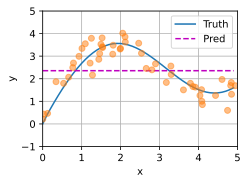

In [5]:
y_hat = jnp.repeat(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

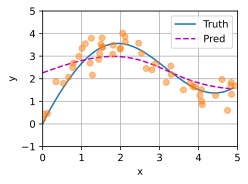

In [10]:
# Shape of `X_repeat`: (`n_test`, `n_train`), where each row contains the
# same testing inputs (i.e., same queries)
X_repeat = x_test.repeat(n_train).reshape((-1, n_train))
# Note that `x_train` contains the keys. Shape of `attention_weights`:
# (`n_test`, `n_train`), where each row contains attention weights to be
# assigned among the values (`y_train`) given each query
attention_weights = jax.nn.softmax(-(X_repeat - x_train)**2 / 2, axis=1)
# Each element of `y_hat` is weighted average of values, where weights are
# attention weights
y_hat = jnp.dot(attention_weights, y_train)
plot_kernel_reg(y_hat)

In [12]:
attention_weights.shape, n_train

((50, 50), 50)

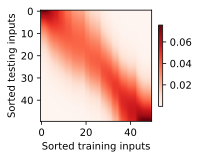

In [13]:
from util import show_heatmaps

show_heatmaps(attention_weights.reshape((1, 1, n_train, n_train)), xlabel='Sorted training inputs', ylabel='Sorted testing inputs')

## Parametric Attention Pooling

### Batch Matrix Multiplication

In [15]:
import torch

X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape


torch.Size([2, 1, 6])

In [23]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
print(values.shape, values.unsqueeze(-1).shape)
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))


torch.Size([2, 10]) torch.Size([2, 10, 1])


tensor([[[ 4.5000]],

        [[14.5000]]])

In [19]:
X = jnp.ones((2, 1, 4))
Y = jnp.ones((2, 4, 6))
jax.lax.batch_matmul(X, Y).shape

(2, 1, 6)

In [27]:
weights = jnp.ones((2, 10)) * 0.1
values = jnp.arange(20.0).reshape((2, 10))
jax.lax.batch_matmul(weights.reshape((weights.shape[0],1,weights.shape[-1])), values.reshape((values.shape[0],values.shape[-1],1)))


DeviceArray([[[ 4.5]],

             [[14.5]]], dtype=float32)

## Defining the Model

In [ ]:
class NWKernelRegression(nn.Module):

  def setup(self):
    # we automatically know what to do with lists, dicts of submodules
    self.layers = [nn.Dense(feat) for feat in self.features]
    # for single submodules, we would just write:
    # self.layer1 = nn.Dense(feat1)

  def __call__(self, queries, keys, values):

key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.uniform(key1, (4,4))

model = ExplicitMLP(features=[3,4,5])
params = model.init(key2, x)
y = model.apply(params, x)

print('initialized parameter shapes:\n', jax.tree_map(jnp.shape, unfreeze(params)))
print('output:\n', y)

In [ ]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # Shape of the output `queries` and `attention_weights`: (no. of queries, no. of key-value pairs)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(-((queries - keys) * self.w)**2 / 2, dim=1)
        # Shape of `values`: (no. of queries, no. of key-value pairs)
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)
